## Text Classification Or Sentiment Analysis with 6 classes viz. ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [3]:
from datasets import list_datasets
all_datasets = list_datasets()

print(f'There are {len(all_datasets)} datasets currently available on the hugging face hub')
print(f'The first 10 are as follows \n',all_datasets[:10])

C:\Users\HP\AppData\Local\Temp\ipykernel_26248\3243947017.py:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 208229 datasets currently available on the hugging face hub
The first 10 are as follows 
 ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


### Data Importing

In [5]:
from datasets import load_dataset
emotions = load_dataset('emotion')

print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


### Data Analysis And EDA

In [7]:
train_ds = emotions['train']

train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
len(train_ds)

16000

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [12]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [13]:
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [14]:
import pandas as pd
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Data Visualization

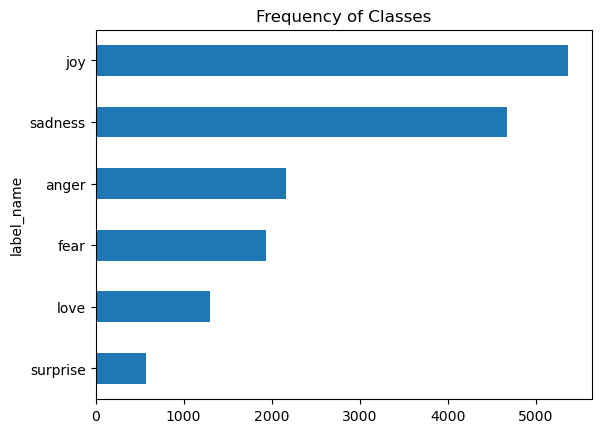

In [17]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

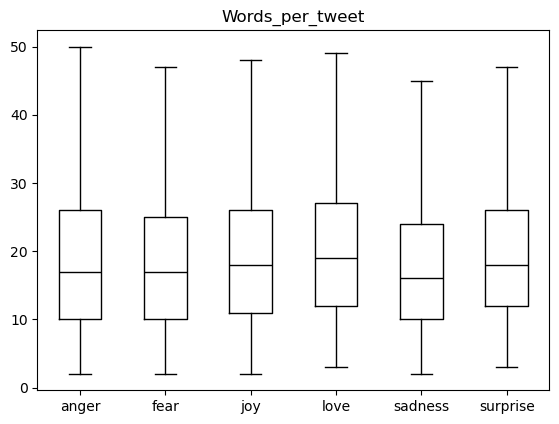

In [18]:
df['Words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words_per_tweet',by='label_name',grid=False,showfliers=False,color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [19]:
emotions.reset_format()

### Tokenization

In [21]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

C:\Users\HP\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [23]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [24]:
emotions_encoded = emotions.map(tokenize, batched=True,batch_size=None)

In [25]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Model Selection and Loading

In [63]:
import torch
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [65]:
def extract_hidden_state(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [67]:
emotions_encoded.set_format('torch',columns=['input_ids','attention_mask','label'])

In [69]:
emotions_hidden = emotions_encoded.map(extract_hidden_state,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [70]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Train test split

In [71]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape,X_valid.shape

((16000, 768), (2000, 768))

In [72]:
!pip install umap-learn

In [73]:
pip install --upgrade keras tensorflow

Note: you may need to restart the kernel to use updated packages.


### Reducing the Dimensions

In [75]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2,metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns=['X','Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.318622,6.998250,0
1,-3.113156,6.376930,0
2,5.196570,3.591876,3
3,-2.310030,4.516774,2
4,-3.335706,4.409122,3


### Checking for the relation between different emotions

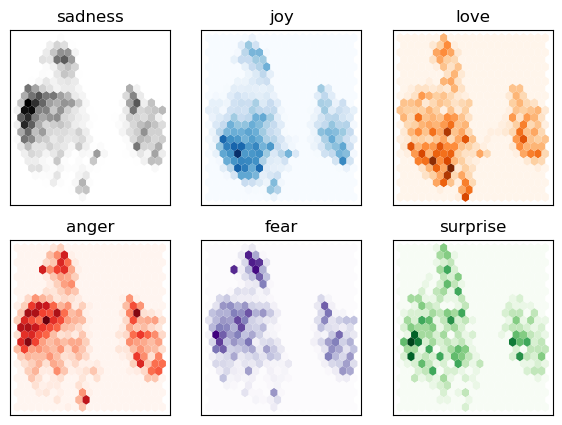

In [77]:
fig,axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys','Blues','Oranges','Reds','Purples','Greens']
labels = emotions['train'].features['label'].names

for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb.query(f'label=={i}')
    axes[i].hexbin(df_emb_sub['X'],df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidth=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]),axes[i].set_yticks([])
plt.show()

## Training Using Simple ML models

In [79]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.6335

In [80]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

### Checking for true and predicted outputs

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred,y_true,labels):
    cm = confusion_matrix(y_true,y_pred,normalize='true')
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap='Blues',values_format='.2f',ax=ax,colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

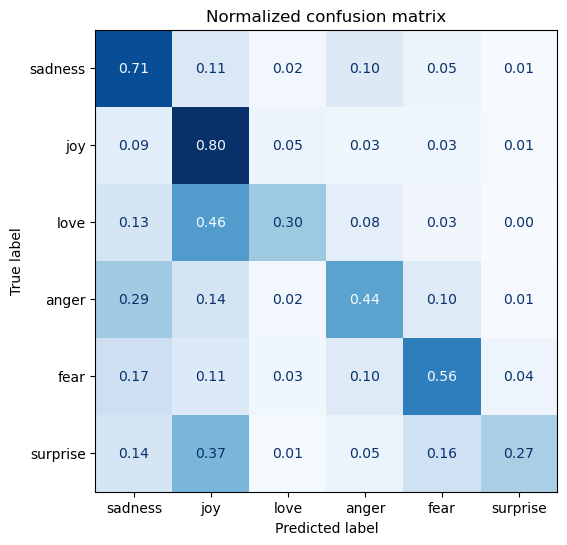

In [83]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

### Fine Tuning The Model

In [85]:
from transformers import AutoModelForSequenceClassification

num_classes = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_classes).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'accuracy': acc, 'f1':f1}

In [87]:
from huggingface_hub import login
login("<token>")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\HP\.cache\huggingface\token
Login successful


In [88]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error'
                                  )

C:\Users\HP\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [89]:
from transformers import Trainer

trainer = Trainer(model=model,args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.845000,0.325167,0.903000,0.902355
2,0.254700,0.222717,0.922000,0.922125


In [90]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [91]:
preds_output.metrics

{'test_loss': 0.2227165549993515,
 'test_accuracy': 0.922,
 'test_f1': 0.922124918293831,
 'test_runtime': 146.8906,
 'test_samples_per_second': 13.616,
 'test_steps_per_second': 0.218}

In [92]:
y_preds = np.argmax(preds_output.predictions, axis=1)

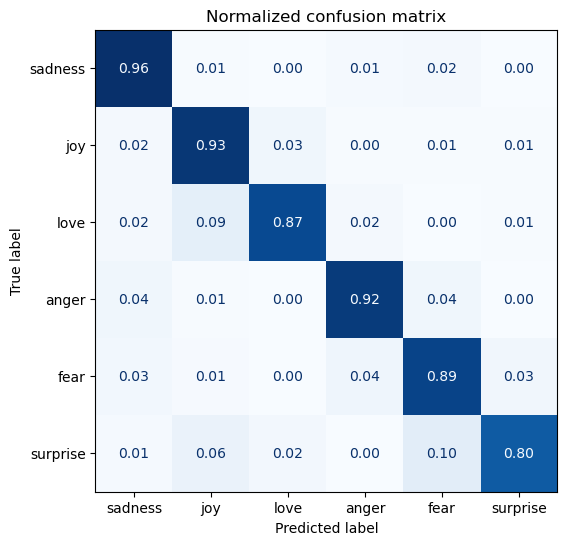

In [93]:
plot_confusion_matrix(y_preds,y_valid,labels)

### Error Analysis

In [95]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits,axis=1)
        loss = cross_entropy(output.logits,batch['label'].to(device),reduction='none')
    return {'loss':loss.cpu().numpy(),'predicted_label':pred_label.cpu().numpy()}

In [96]:
emotions_encoded.set_format('torch',columns=['input_ids','attention_mask','label'])

emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True,batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [97]:
emotions_encoded.set_format('pandas')
cols = ['text','label','predicted_label','loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['labels'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = (df_test['predicted_label'].apply(label_int2str))

In [98]:
df_test.sort_values('loss',ascending=False).head(10)

,text,label,predicted_label,loss,labels
1963,i called myself pro life and voted for perry w...,1,sadness,5.688555,joy
1801,i feel that he was being overshadowed by the s...,2,sadness,5.374349,love
1870,i guess i feel betrayed because i admired him ...,1,sadness,5.330613,joy
1111,im lazy my characters fall into categories of ...,1,fear,4.964365,joy
1509,i guess this is a memoir so it feels like that...,1,fear,4.910126,joy
1274,i am going to several holiday parties and i ca...,1,sadness,4.807243,joy
882,i feel badly about reneging on my commitment t...,2,sadness,4.748764,love
1500,i guess we would naturally feel a sense of lon...,3,sadness,4.646742,anger
318,i felt ashamed of these feelings and was scare...,4,sadness,4.642000,fear
465,i would eventually go in to these stores but i...,1,fear,4.614001,joy


In [99]:
df_test.sort_values('loss',ascending=True).head(10)

,text,label,predicted_label,loss,labels
1861,im tired of feeling lethargic hating to work o...,0,sadness,0.017552,sadness
21,i feel try to tell me im ungrateful tell me im...,0,sadness,0.017565,sadness
1873,i feel practically virtuous this month i have ...,1,joy,0.017580,joy
1310,i feel like an ungrateful asshole,0,sadness,0.017612,sadness
1147,i type i feel bouncy and excited to get out my...,1,joy,0.017733,joy
244,im kinda relieve but at the same time i feel d...,0,sadness,0.017910,sadness
189,i leave the meeting feeling more than a little...,0,sadness,0.017958,sadness
1140,i do think about certain people i feel a bit d...,0,sadness,0.018121,sadness
133,i and feel quite ungrateful for it but i m loo...,0,sadness,0.018131,sadness
1502,i feel ungrateful for stupid shit like,0,sadness,0.018153,sadness


### Pushing the model into the hub

In [101]:
trainer.push_to_hub(commit_message='Training completed')

events.out.tfevents.1726068467.LAPTOP-8VQT08OC.26248.0:   0%|          | 0.00/6.64k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Igniter909/distilbert-base-uncased-finetuned-emotion/commit/b154676f038980baee5112d2d77af9a518fde5f7', commit_message='Training completed', commit_description='', oid='b154676f038980baee5112d2d77af9a518fde5f7', pr_url=None, pr_revision=None, pr_num=None)

### Importing the model

In [10]:
from transformers import pipeline

model_id = 'Igniter909/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification',model=model_id)

In [11]:
custom_tweet = 'I saw a movie today and it was really good'
preds = classifier(custom_tweet,return_all_scores=True)

C:\Users\HP\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
preds_df = pd.DataFrame(preds[0])
plt.bar(labels,100*preds_df['score'],color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

NameError: name 'labels' is not defined

### Custom function for checking the sentiment

In [21]:
custom_tweet = 'Happr Birthday Ansh'
preds = classifier(custom_tweet,return_all_scores=True)
print(pd.DataFrame(preds[0]))

     label     score
0  LABEL_0  0.111664
1  LABEL_1  0.698033
2  LABEL_2  0.072852
3  LABEL_3  0.058093
4  LABEL_4  0.032707
5  LABEL_5  0.026651


C:\Users\HP\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [23]:
def find_sentiment(Generate):
    if(Generate):
        text = input("Enter the text or tweet : ")
        preds = classifier(text,return_all_scores=True)
        data = pd.DataFrame(preds[0])
        max_label = data.loc[data['score'].idxmax(),'label']
        print("The sentiment is ",max_label)

In [25]:
Generate = True
find_sentiment(Generate)

Enter the text or tweet :  good movie and nice animation with graphics


The sentiment is  LABEL_1


C:\Users\HP\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
